# **Convolutional Neural Network Notebook**

## Objectives
Answer business requirement 2:
The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs
* 'inputs/leaves_dataset/cherry-leaves/processed_images/test'
* 'inputs/leaves_dataset/cherry-leaves/processed_images/train'
* 'inputs/leaves_dataset/cherry-leaves/processed_images/validation'
* image shape embeddings.

## Outputs
* Image distribution plots for train, validation, and test sets.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.

---

### Import Libraries

In [ ]:
import os
import joblib
import shutil
import re
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

2025-04-29 10:40:29.555037: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 10:40:29.556537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 10:40:29.559752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 10:40:29.571128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745923229.586435    1487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745923229.59

### Set Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves'

---

### Setting Input Directories

In [5]:
my_data_dir = 'inputs/leaves_dataset/cherry-leaves/processed_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Setting Output Directory

Automatic Version Control moves all files and directories to the latest version folder, and
removes any now-empty previous version folders.

In [6]:
def get_version_folders(base_path):
    version_folders = []
    for folder in os.listdir(base_path):
        full_path = os.path.join(base_path, folder)
        if os.path.isdir(full_path) and re.match(r'^v\d+$', folder):
            version_folders.append((int(folder[1:]), folder))
    return sorted(version_folders)

def move_files_to_latest(base_path):
    version_folders = get_version_folders(base_path)
    if not version_folders:
        print("No version folders found.")
        return

    latest_version_num, latest_version = version_folders[-1]
    latest_path = os.path.join(base_path, latest_version)

    for version_num, version_name in version_folders[:-1]:
        version_path = os.path.join(base_path, version_name)
        for root, dirs, files in os.walk(version_path, topdown=False):
            for file in files:
                src_file = os.path.join(root, file)
                relative_path = os.path.relpath(src_file, version_path)
                dest_file = os.path.join(latest_path, relative_path)

                os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                shutil.move(src_file, dest_file)

            for dir in dirs:
                dir_path = os.path.join(root, dir)
                if not os.listdir(dir_path):  # Remove empty subdirs
                    os.rmdir(dir_path)

        # After moving, remove version folder if empty
        if not os.listdir(version_path):
            os.rmdir(version_path)
            print(f"Removed empty folder: {version_name}")

    print(f"✅ All files moved to: {latest_version}")

if __name__ == "__main__":
    base_directory = '/workspaces/PP5-Cherry-Leaves/outputs'  # 🔧 Change this to your folder path
    move_files_to_latest(base_directory)

✅ All files moved to: v13


---

keeping consistency and moving the model file for easier location access instead of storing them in version files.

In [7]:
# Base outputs directory
output_path = '/workspaces/PP5-Cherry-Leaves/outputs'

# Find all version folders like v1, v2, v3...
version_folders = [
    f for f in os.listdir(output_path)
    if os.path.isdir(os.path.join(output_path, f)) and re.match(r'^v\d+$', f)
]

# If no version folders, stop
if not version_folders:
    raise FileNotFoundError("❌ No version folders found in outputs/")

# Sort and get the latest version folder (e.g., v3 is newer than v2)
version_folders.sort(key=lambda x: int(x[1:]))  # Sort by number after 'v'
latest_version = version_folders[-1]
latest_version_path = os.path.join(output_path, latest_version)

print(f"📦 Latest version folder: {latest_version}")

# File types to move
file_extensions = ('.pkl', '.h5')

# Move files to top-level outputs
for file in os.listdir(latest_version_path):
    if file.endswith(file_extensions):
        src = os.path.join(latest_version_path, file)
        dest = os.path.join(output_path, file)

        # Avoid overwriting
        base, ext = os.path.splitext(file)
        counter = 1
        while os.path.exists(dest):
            dest = os.path.join(output_path, f"{base}_{counter}{ext}")
            counter += 1

        shutil.move(src, dest)
        print(f"✅ Moved: {file} → outputs/")

print("\n🏁 Done! All relevant files moved from the latest version folder.")


📦 Latest version folder: v13

🏁 Done! All relevant files moved from the latest version folder.


Duplicate identified after moving the files from above to the correct location. removal in process.

In [8]:
# Path to the outputs directory
output_path = '/workspaces/PP5-Cherry-Leaves/outputs'

# Target duplicate file
duplicate_filename = 'image_shape_1_1.pkl'
duplicate_path = os.path.join(output_path, duplicate_filename)

# Check and delete
if os.path.exists(duplicate_path):
    os.remove(duplicate_path)
    print(f"🗑️ Removed duplicate file: {duplicate_filename}")
else:
    print(f"⚠️ File not found: {duplicate_filename}")

⚠️ File not found: image_shape_1_1.pkl


---

Setting Labels

In [9]:
labels = os.listdir(train_path)

print(
    f"Cherry Leaf Labels are: {labels}"
)

Cherry Leaf Labels are: ['powdery_mildew', 'healthy']


Setting Image Shape

In [10]:
# Settings
file_path = '/workspaces/PP5-Cherry-Leaves/outputs'  # Same directory
file_prefix = 'image_shape'
file_extension = '.pkl'

# Get list of all matching pickle files
existing_files = [
    f for f in os.listdir(file_path)
    if f.startswith(file_prefix + '_') and f.endswith(file_extension)
]

if not existing_files:
    raise FileNotFoundError("❌ No image_shape pickle files found!")

# Sort files by number suffix (e.g., image_shape_1.pkl → 1)
existing_files.sort(key=lambda x: int(x[len(file_prefix) + 1:-len(file_extension)]))

# Load the most recent one
latest_file = existing_files[-1]
latest_path = os.path.join(file_path, latest_file)

with open(latest_path, 'rb') as f:
    image_shape = pickle.load(f)

print(f"✅ Loaded image shape from: {latest_path}")
print("Image shape:", image_shape)

✅ Loaded image shape from: /workspaces/PP5-Cherry-Leaves/outputs/image_shape_2.pkl
Image shape: (100, 100, 3)


---

### Number of images in Train, Test and Validation datasets

Plot generation from a dictionary containing image frequency across all data subsets.

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 311 images
* validation - healthy: 311 images
* test - powdery_mildew: 317 images
* test - healthy: 317 images




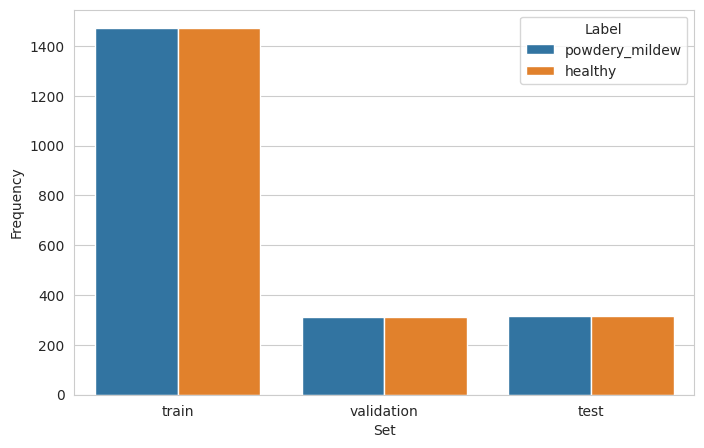

In [11]:
# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation

Initialise ImageDataGenerator for Image Augmentation

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augmenting Training images dataset

In [13]:
batch_size = 10  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmenting Validation images dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 622 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmenting Testing images dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 634 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmented training image

(10, 100, 100, 3)


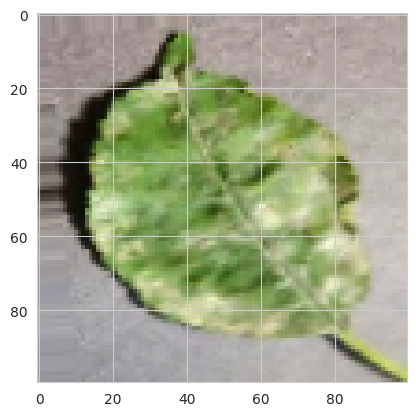

(10, 100, 100, 3)


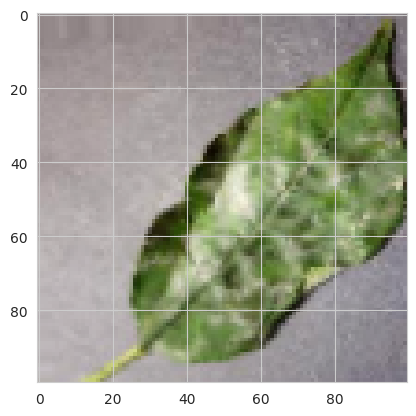

(10, 100, 100, 3)


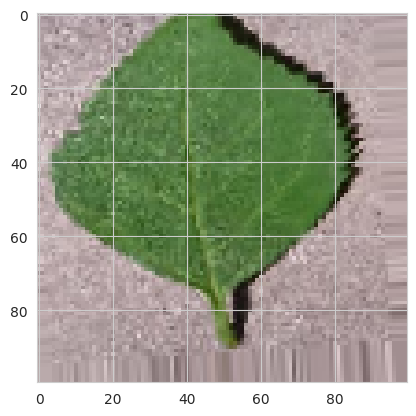

In [ ]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (10,100,100,3)
    plt.imshow(img[0])
    plt.show()

Augmented Validation image

(10, 100, 100, 3)


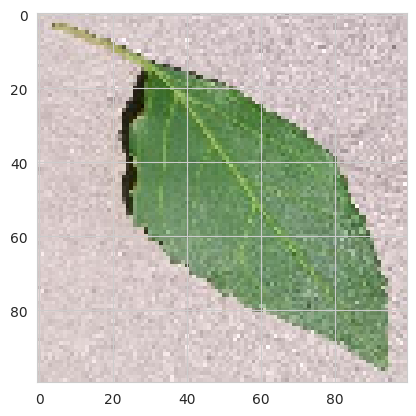

(10, 100, 100, 3)


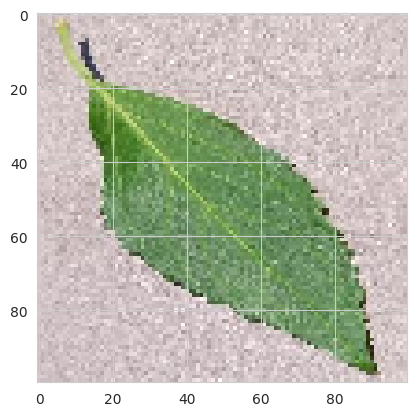

(10, 100, 100, 3)


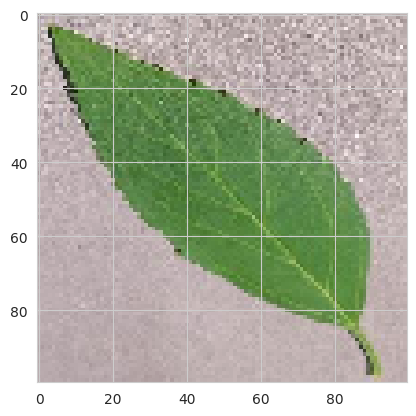

In [ ]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (10,100,100,3)
    plt.imshow(img[0])
    plt.show()

Augmented testing image

(10, 100, 100, 3)


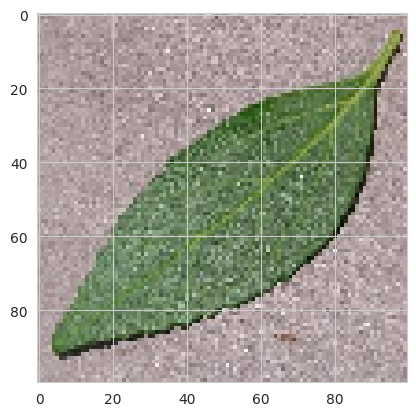

(10, 100, 100, 3)


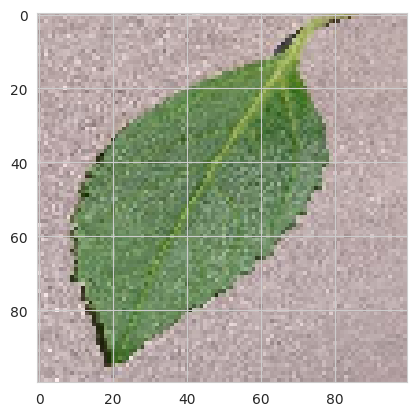

(10, 100, 100, 3)


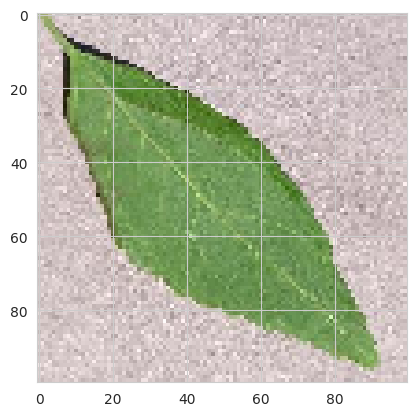

In [ ]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (10,100,100,3)
    plt.imshow(img[0])
    plt.show()

Save Class Indices

In [18]:
# Define the outputs directory
output_path = '/workspaces/PP5-Cherry-Leaves/outputs'

# Ensure the outputs directory exists
os.makedirs(output_path, exist_ok=True)

# Get the next number for the class_indices pickle file to avoid overwriting
file_prefix = 'class_indices'
file_extension = '.pkl'

# List all existing class_indices files
existing_files = [
    f for f in os.listdir(output_path)
    if f.startswith(file_prefix) and f.endswith(file_extension)
]

# Extract numbers from filenames (like class_indices_1.pkl)
existing_numbers = [
    int(f[len(file_prefix) + 1:-len(file_extension)])
    for f in existing_files
    if f[len(file_prefix) + 1:-len(file_extension)].isdigit()
]

# Determine the next number to use
next_number = max(existing_numbers, default=0) + 1
new_filename = f"{file_prefix}_{next_number}{file_extension}"
full_save_path = os.path.join(output_path, new_filename)

# Save the class_indices using joblib
joblib.dump(value=train_set.class_indices, filename=full_save_path)

print(f"✅ class_indices saved to: {full_save_path}")

✅ class_indices saved to: /workspaces/PP5-Cherry-Leaves/outputs/class_indices_2.pkl


---